In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import imageio
import glob
from IPython import display
import PIL


2025-12-12 21:55:00.598028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765576500.779263      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765576500.832406      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
IMG_SIZE = 64   # Larger size for better colored images
CHANNELS = 3    # RGB
BATCH_SIZE = 64

dataset_path = "/kaggle/input/footwear"  # <

# Load dataset in color
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE
)

# Normalize images to [-1, 1]
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)


Found 3000 files.


I0000 00:00:1765576560.027230      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # RGB output
    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh"))

    return model


In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding="same", input_shape=[IMG_SIZE, IMG_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model


In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
checkpoint_dir = './training_checkpoints_footwear_rgb'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)


In [7]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [10]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # Convert tensor to numpy array before casting
        img = predictions[i].numpy()  # <-- convert to numpy
        plt.imshow((img * 127.5 + 127.5).astype(np.uint8))  # now works
        plt.axis('off')

    plt.savefig('footwear_rgb_epoch_{:04d}.png'.format(epoch))
    plt.show()


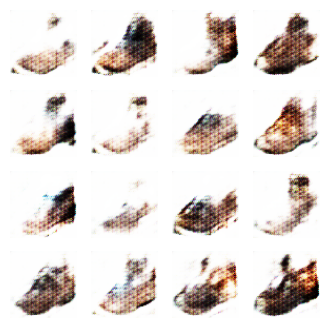

Time for epoch 84: 2.05 sec


In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f"Time for epoch {epoch+1}: {time.time()-start:.2f} sec")

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

train(train_dataset, EPOCHS)


In [14]:
import imageio.v2 as imageio
import glob
from IPython.display import HTML

# Create GIF
anim_file = 'footwear_rgb_gan.gif'

with imageio.get_writer(anim_file, mode='I', duration=0.5) as writer:  # duration=0.5 sec per frame
    filenames = glob.glob('footwear_rgb_epoch_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Display GIF in notebook
HTML(f'<img src="{anim_file}" width="400">')

